# Delta objects

> Auxiliary delta classes for estimating statistics and generating plots.

- order: 9

In [ ]:
#| default_exp _delta_objects

In [ ]:
#| hide
from __future__ import annotations

In [ ]:
#| hide
from nbdev.showdoc import *
import nbdev
nbdev.nbdev_export()

In [ ]:
#| hide
import dabest

In [ ]:
#| export
from scipy.stats import norm
import pandas as pd
import numpy as np
from numpy import sort as npsort
from numpy import isnan
from string import Template
import warnings
import datetime as dt

In [ ]:
#| export
class DeltaDelta(object):
    """
    A class to compute and store the delta-delta statistics for experiments with a 2-by-2 arrangement where two independent variables, A and B, each have two categorical values, 1 and 2. The data is divided into two pairs of two groups, and a primary delta is first calculated as the mean difference between each of the pairs:


    $$\Delta_{1} = \overline{X}_{A_{2}, B_{1}} - \overline{X}_{A_{1}, B_{1}}$$

    $$\Delta_{2} = \overline{X}_{A_{2}, B_{2}} - \overline{X}_{A_{1}, B_{2}}$$


    where $\overline{X}_{A_{i}, B_{j}}$ is the mean of the sample with A = i and B = j, $\Delta$ is the mean difference between two samples.

    A delta-delta value is then calculated as the mean difference between the two primary deltas:


    $$\Delta_{\Delta} = \Delta_{2} - \Delta_{1}$$

    and a deltas' g value is calculated as the mean difference between the two primary deltas divided by
    the standard deviation of the delta-delta value, which is calculated from a pooled variance of the 4 samples:

    $$\Delta_{g} = \frac{\Delta_{\Delta}}{s_{\Delta_{\Delta}}}$$

    $$s_{\Delta_{\Delta}} = \sqrt{\frac{(n_{A_{2}, B_{1}}-1)s_{A_{2}, B_{1}}^2+(n_{A_{1}, B_{1}}-1)s_{A_{1}, B_{1}}^2+(n_{A_{2}, B_{2}}-1)s_{A_{2}, B_{2}}^2+(n_{A_{1}, B_{2}}-1)s_{A_{1}, B_{2}}^2}{(n_{A_{2}, B_{1}} - 1) + (n_{A_{1}, B_{1}} - 1) + (n_{A_{2}, B_{2}} - 1) + (n_{A_{1}, B_{2}} - 1)}}$$

    where $s$ is the standard deviation and $n$ is the sample size.


    """

    def __init__(
        self, effectsizedataframe, permutation_count, bootstraps_delta_delta, ci=95
    ):
        from ._stats_tools import effsize as es
        from ._stats_tools import confint_1group as ci1g
        from ._stats_tools import confint_2group_diff as ci2g

        self.__effsizedf = effectsizedataframe.results
        self.__dabest_obj = effectsizedataframe.dabest_obj
        self.__ci = ci
        self.__resamples = effectsizedataframe.resamples
        self.__effect_size = effectsizedataframe.effect_size
        self.__alpha = ci2g._compute_alpha_from_ci(ci)
        self.__permutation_count = permutation_count
        self.__bootstraps = np.array(self.__effsizedf["bootstraps"])
        self.__control = self.__dabest_obj.experiment_label[0]
        self.__test = self.__dabest_obj.experiment_label[1]

        # Compute the bootstrap delta-delta or deltas' g and the true dela-delta based on the raw data
        if self.__effect_size == "mean_diff":
            self.__bootstraps_delta_delta = bootstraps_delta_delta[2]
            self.__difference = (
                self.__effsizedf["difference"][1] - self.__effsizedf["difference"][0]
            )
        else:
            self.__bootstraps_delta_delta = bootstraps_delta_delta[0]
            self.__difference = bootstraps_delta_delta[1]

        sorted_delta_delta = npsort(self.__bootstraps_delta_delta)

        self.__bias_correction = ci2g.compute_meandiff_bias_correction(
            self.__bootstraps_delta_delta, self.__difference
        )

        self.__jackknives = np.array(
            ci1g.compute_1group_jackknife(self.__bootstraps_delta_delta, np.mean)
        )

        self.__acceleration_value = ci2g._calc_accel(self.__jackknives)

        # Compute BCa intervals.
        bca_idx_low, bca_idx_high = ci2g.compute_interval_limits(
            self.__bias_correction, self.__acceleration_value, self.__resamples, ci
        )

        self.__bca_interval_idx = (bca_idx_low, bca_idx_high)

        if ~isnan(bca_idx_low) and ~isnan(bca_idx_high):
            self.__bca_low = sorted_delta_delta[bca_idx_low]
            self.__bca_high = sorted_delta_delta[bca_idx_high]

            err1 = "The $lim_type limit of the interval"
            err2 = "was in the $loc 10 values."
            err3 = "The result should be considered unstable."
            err_temp = Template(" ".join([err1, err2, err3]))

            if bca_idx_low <= 10:
                warnings.warn(
                    err_temp.substitute(lim_type="lower", loc="bottom"), stacklevel=1
                )

            if bca_idx_high >= self.__resamples - 9:
                warnings.warn(
                    err_temp.substitute(lim_type="upper", loc="top"), stacklevel=1
                )

        else:
            err1 = "The $lim_type limit of the BCa interval cannot be computed."
            err2 = "It is set to the effect size itself."
            err3 = "All bootstrap values were likely all the same."
            err_temp = Template(" ".join([err1, err2, err3]))

            if isnan(bca_idx_low):
                self.__bca_low = self.__difference
                warnings.warn(err_temp.substitute(lim_type="lower"), stacklevel=0)

            if isnan(bca_idx_high):
                self.__bca_high = self.__difference
                warnings.warn(err_temp.substitute(lim_type="upper"), stacklevel=0)

        # Compute percentile intervals.
        pct_idx_low = int((self.__alpha / 2) * self.__resamples)
        pct_idx_high = int((1 - (self.__alpha / 2)) * self.__resamples)

        self.__pct_interval_idx = (pct_idx_low, pct_idx_high)
        self.__pct_low = sorted_delta_delta[pct_idx_low]
        self.__pct_high = sorted_delta_delta[pct_idx_high]

    def __permutation_test(self):
        """
        Perform a permutation test and obtain the permutation p-value
        based on the permutation data.
        """
        self.__permutations = np.array(self.__effsizedf["permutations"])

        THRESHOLD = np.abs(self.__difference)

        self.__permutations_delta_delta = np.array(
            self.__permutations[1] - self.__permutations[0]
        )

        count = sum(np.abs(self.__permutations_delta_delta) > THRESHOLD)
        self.__pvalue_permutation = count / self.__permutation_count

    def __repr__(self, header=True, sigfig=3):
        from .misc_tools import print_greeting

        first_line = {"control": self.__control, "test": self.__test}

        if self.__effect_size == "mean_diff":
            out1 = "The delta-delta between {control} and {test} ".format(**first_line)
        else:
            out1 = "The deltas' g between {control} and {test} ".format(**first_line)

        base_string_fmt = "{:." + str(sigfig) + "}"
        if "." in str(self.__ci):
            ci_width = base_string_fmt.format(self.__ci)
        else:
            ci_width = str(self.__ci)

        ci_out = {
            "es": base_string_fmt.format(self.__difference),
            "ci": ci_width,
            "bca_low": base_string_fmt.format(self.__bca_low),
            "bca_high": base_string_fmt.format(self.__bca_high),
        }

        out2 = "is {es} [{ci}%CI {bca_low}, {bca_high}].".format(**ci_out)
        out = out1 + out2

        if header is True:
            out = print_greeting() + "\n" + "\n" + out

        pval_rounded = base_string_fmt.format(self.pvalue_permutation)

        p1 = "The p-value of the two-sided permutation t-test is {}, ".format(
            pval_rounded
        )
        p2 = "calculated for legacy purposes only. "
        pvalue = p1 + p2

        bs1 = "{} bootstrap samples were taken; ".format(self.__resamples)
        bs2 = "the confidence interval is bias-corrected and accelerated."
        bs = bs1 + bs2

        pval_def1 = (
            "Any p-value reported is the probability of observing the "
            + "effect size (or greater),\nassuming the null hypothesis of "
            + "zero difference is true."
        )
        pval_def2 = (
            "\nFor each p-value, 5000 reshuffles of the "
            + "control and test labels were performed."
        )
        pval_def = pval_def1 + pval_def2

        return "{}\n{}\n\n{}\n{}".format(out, pvalue, bs, pval_def)

    def to_dict(self):
        """
        Returns the attributes of the `DeltaDelta` object as a
        dictionary.
        """
        # Only get public (user-facing) attributes.
        attrs = [a for a in dir(self) if not a.startswith(("_", "to_dict", "results"))]
        out = {}
        for a in attrs:
            out[a] = getattr(self, a)
        return out
    
    def __compute_results(self):
        # With some inspiration from @jungyangliao
        delta_delta_results_df = pd.Series(self.to_dict()).to_frame().T

        column_index = ['control', 'test', 'difference', 'ci', 'bca_low', 'bca_high', 'bca_interval_idx', 
                        'pct_low', 'pct_high', 'pct_interval_idx', 'bootstraps_control', 'bootstraps_test', 
                        'bootstraps_delta_delta', 'permutations_control', 'permutations_test', 'permutations_delta_delta',
                        'pvalue_permutation', 'permutation_count', 'bias_correction', 'jackknives'
                        ]
        delta_delta_results_df['bootstraps_control'] = [delta_delta_results_df['bootstraps'][0][0]]
        delta_delta_results_df['bootstraps_test'] = [delta_delta_results_df['bootstraps'][0][1]]
        delta_delta_results_df['permutations_control'] = [delta_delta_results_df['permutations'][0][0]]
        delta_delta_results_df['permutations_test'] = [delta_delta_results_df['permutations'][0][1]]
        delta_delta_results_df = delta_delta_results_df.reindex(columns=column_index)

        self.__results = delta_delta_results_df
        return self.__results

    @property
    def ci(self):
        """
        Returns the width of the confidence interval, in percent.
        """
        return self.__ci

    @property
    def alpha(self):
        """
        Returns the significance level of the statistical test as a float
        between 0 and 1.
        """
        return self.__alpha

    @property
    def bias_correction(self):
        return self.__bias_correction

    @property
    def bootstraps(self):
        """
        Return the bootstrapped deltas from all the experiment groups.
        """
        return self.__bootstraps

    @property
    def jackknives(self):
        return self.__jackknives

    @property
    def acceleration_value(self):
        return self.__acceleration_value

    @property
    def bca_low(self):
        """
        The bias-corrected and accelerated confidence interval lower limit.
        """
        return self.__bca_low

    @property
    def bca_high(self):
        """
        The bias-corrected and accelerated confidence interval upper limit.
        """
        return self.__bca_high

    @property
    def bca_interval_idx(self):
        return self.__bca_interval_idx

    @property
    def control(self):
        """
        Return the name of the control experiment group.
        """
        return self.__control

    @property
    def test(self):
        """
        Return the name of the test experiment group.
        """
        return self.__test

    @property
    def bootstraps_delta_delta(self):
        """
        Return the delta-delta values calculated from the bootstrapped
        deltas.
        """
        return self.__bootstraps_delta_delta

    @property
    def difference(self):
        """
        Return the delta-delta value calculated based on the raw data.
        """
        return self.__difference

    @property
    def pct_interval_idx(self):
        return self.__pct_interval_idx

    @property
    def pct_low(self):
        """
        The percentile confidence interval lower limit.
        """
        return self.__pct_low

    @property
    def pct_high(self):
        """
        The percentile confidence interval lower limit.
        """
        return self.__pct_high

    @property
    def pvalue_permutation(self):
        try:
            return self.__pvalue_permutation
        except AttributeError:
            self.__permutation_test()
            return self.__pvalue_permutation

    @property
    def permutation_count(self):
        """
        The number of permuations taken.
        """
        return self.__permutation_count

    @property
    def permutations(self):
        """
        Return the mean differences of permutations obtained during
        the permutation test for each experiment group.
        """
        try:
            return self.__permutations
        except AttributeError:
            self.__permutation_test()
            return self.__permutations

    @property
    def permutations_delta_delta(self):
        """
        Return the delta-delta values of permutations obtained
        during the permutation test.
        """
        try:
            return self.__permutations_delta_delta
        except AttributeError:
            self.__permutation_test()
            return self.__permutations_delta_delta
        
    @property
    def results(self):
        """
        Return the results of the delta-delta analysis.
        """
        try:
            return self.__results
        except AttributeError:
            self.__compute_results()
        return self.__results



and the standard deviation of the delta-delta value is calculated from a pooled variance of the 4 samples:


$$s_{\Delta_{\Delta}} = \sqrt{\frac{(n_{A_{2}, B_{1}}-1)s_{A_{2}, B_{1}}^2+(n_{A_{1}, B_{1}}-1)s_{A_{1}, B_{1}}^2+(n_{A_{2}, B_{2}}-1)s_{A_{2}, B_{2}}^2+(n_{A_{1}, B_{2}}-1)s_{A_{1}, B_{2}}^2}{(n_{A_{2}, B_{1}} - 1) + (n_{A_{1}, B_{1}} - 1) + (n_{A_{2}, B_{2}} - 1) + (n_{A_{1}, B_{2}} - 1)}}$$

where $s$ is the standard deviation and $n$ is the sample size.

#### Example: delta-delta

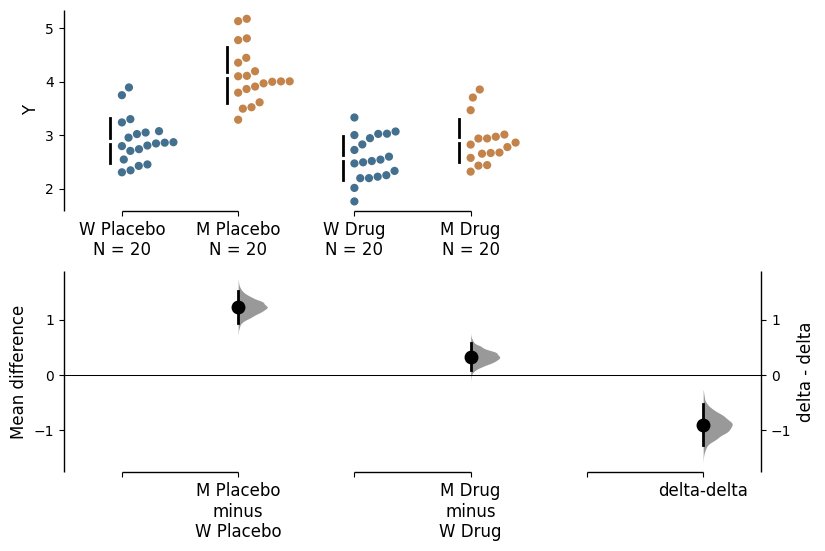

In [ ]:
np.random.seed(9999) # Fix the seed so the results are replicable.
N = 20
# Create samples
y = norm.rvs(loc=3, scale=0.4, size=N*4)
y[N:2*N] = y[N:2*N]+1
y[2*N:3*N] = y[2*N:3*N]-0.5
# Add a `Treatment` column
t1 = np.repeat('Placebo', N*2).tolist()
t2 = np.repeat('Drug', N*2).tolist()
treatment = t1 + t2 
# Add a `Rep` column as the first variable for the 2 replicates of experiments done
rep = []
for i in range(N*2):
    rep.append('Rep1')
    rep.append('Rep2')
# Add a `Genotype` column as the second variable
wt = np.repeat('W', N).tolist()
mt = np.repeat('M', N).tolist()
wt2 = np.repeat('W', N).tolist()
mt2 = np.repeat('M', N).tolist()
genotype = wt + mt + wt2 + mt2
# Add an `id` column for paired data plotting.
id = list(range(0, N*2))
id_col = id + id 
# Combine all columns into a DataFrame.
df_delta2 = pd.DataFrame({'ID'        : id_col,
                  'Rep'      : rep,
                   'Genotype'  : genotype, 
                   'Treatment': treatment,
                   'Y'         : y
                })
unpaired_delta2 = dabest.load(data = df_delta2, x = ["Genotype", "Genotype"], y = "Y", delta2 = True, experiment = "Treatment")
unpaired_delta2.mean_diff.plot();

In [ ]:
#| export
class MiniMetaDelta(object):
    """
    A class to compute and store the weighted delta.
    A weighted delta is calculated if the argument ``mini_meta=True`` is passed during ``dabest.load()``.
    
    """

    def __init__(self, effectsizedataframe, permutation_count,
                ci=95):
        from ._stats_tools import effsize as es
        from ._stats_tools import confint_1group as ci1g
        from ._stats_tools import confint_2group_diff as ci2g
        
        self.__effsizedf         = effectsizedataframe.results
        self.__dabest_obj        = effectsizedataframe.dabest_obj
        self.__ci                = ci
        self.__resamples         = effectsizedataframe.resamples
        self.__alpha             = ci2g._compute_alpha_from_ci(ci)
        self.__permutation_count = permutation_count
        self.__bootstraps        = np.array(self.__effsizedf["bootstraps"])
        self.__control           = np.array(self.__effsizedf["control"])
        self.__test              = np.array(self.__effsizedf["test"])
        self.__control_N         = np.array(self.__effsizedf["control_N"])
        self.__test_N            = np.array(self.__effsizedf["test_N"])


        idx  = self.__dabest_obj.idx
        dat  = self.__dabest_obj._plot_data
        xvar = self.__dabest_obj._xvar
        yvar = self.__dabest_obj._yvar

        # compute the variances of each control group and each test group
        control_var=[]
        test_var=[]
        grouped_data = {name: group[yvar].copy() for name, group in dat.groupby(xvar, observed=False)}
        for j, current_tuple in enumerate(idx):
            cname = current_tuple[0]
            control = grouped_data[cname]
            control_var.append(np.var(control, ddof=1))

            tname = current_tuple[1]
            test = grouped_data[tname]
            test_var.append(np.var(test, ddof=1))
        self.__control_var = np.array(control_var)
        self.__test_var    = np.array(test_var)

        # Compute pooled group variances for each pair of experiment groups
        # based on the raw data
        self.__group_var   = ci2g.calculate_group_var(self.__control_var, 
                                                 self.__control_N,
                                                 self.__test_var, 
                                                 self.__test_N)

        # Compute the weighted average mean differences of the bootstrap data
        # using the pooled group variances of the raw data as the inverse of 
        # weights
        self.__bootstraps_weighted_delta = ci2g.calculate_weighted_delta(
                                                          self.__group_var, 
                                                          self.__bootstraps)

        # Compute the weighted average mean difference based on the raw data
        self.__difference = es.weighted_delta(np.array(self.__effsizedf["difference"]),
                                                   self.__group_var)

        sorted_weighted_deltas = npsort(self.__bootstraps_weighted_delta)


        self.__bias_correction = ci2g.compute_meandiff_bias_correction(
                                    self.__bootstraps_weighted_delta, self.__difference)
        
        self.__jackknives = np.array(ci1g.compute_1group_jackknife(
                                                self.__bootstraps_weighted_delta, 
                                                np.mean))

        self.__acceleration_value = ci2g._calc_accel(self.__jackknives)

        # Compute BCa intervals.
        bca_idx_low, bca_idx_high = ci2g.compute_interval_limits(
            self.__bias_correction, self.__acceleration_value,
            self.__resamples, ci)
        
        self.__bca_interval_idx = (bca_idx_low, bca_idx_high)

        if ~isnan(bca_idx_low) and ~isnan(bca_idx_high):
            self.__bca_low  = sorted_weighted_deltas[bca_idx_low]
            self.__bca_high = sorted_weighted_deltas[bca_idx_high]

            err1 = "The $lim_type limit of the interval"
            err2 = "was in the $loc 10 values."
            err3 = "The result should be considered unstable."
            err_temp = Template(" ".join([err1, err2, err3]))

            if bca_idx_low <= 10:
                warnings.warn(err_temp.substitute(lim_type="lower",
                                                  loc="bottom"),
                              stacklevel=1)

            if bca_idx_high >= self.__resamples-9:
                warnings.warn(err_temp.substitute(lim_type="upper",
                                                  loc="top"),
                              stacklevel=1)

        else:
            err1 = "The $lim_type limit of the BCa interval cannot be computed."
            err2 = "It is set to the effect size itself."
            err3 = "All bootstrap values were likely all the same."
            err_temp = Template(" ".join([err1, err2, err3]))

            if isnan(bca_idx_low):
                self.__bca_low  = self.__difference
                warnings.warn(err_temp.substitute(lim_type="lower"),
                              stacklevel=0)

            if isnan(bca_idx_high):
                self.__bca_high  = self.__difference
                warnings.warn(err_temp.substitute(lim_type="upper"),
                              stacklevel=0)

        # Compute percentile intervals.
        pct_idx_low  = int((self.__alpha/2)     * self.__resamples)
        pct_idx_high = int((1-(self.__alpha/2)) * self.__resamples)

        self.__pct_interval_idx = (pct_idx_low, pct_idx_high)
        self.__pct_low          = sorted_weighted_deltas[pct_idx_low]
        self.__pct_high         = sorted_weighted_deltas[pct_idx_high]
        
    

    def __permutation_test(self):
        """
        Perform a permutation test and obtain the permutation p-value
        based on the permutation data.
        """
        self.__permutations     = np.array(self.__effsizedf["permutations"])
        self.__permutations_var = np.array(self.__effsizedf["permutations_var"])

        THRESHOLD = np.abs(self.__difference)

        all_num = []
        all_denom = []

        groups = len(self.__permutations)
        for i in range(0, len(self.__permutations[0])):
            weight = [1/self.__permutations_var[j][i] for j in range(0, groups)]
            all_num.append(np.sum([weight[j]*self.__permutations[j][i] for j in range(0, groups)]))
            all_denom.append(np.sum(weight))
        
        output=[]
        for i in range(0, len(all_num)):
            output.append(all_num[i]/all_denom[i])
        
        self.__permutations_weighted_delta = np.array(output)

        count = sum(np.abs(self.__permutations_weighted_delta)>THRESHOLD)
        self.__pvalue_permutation = count/self.__permutation_count



    def __repr__(self, header=True, sigfig=3):
        from .misc_tools import print_greeting
        
        is_paired = self.__dabest_obj.is_paired

        PAIRED_STATUS = {'baseline'   : 'paired', 
                         'sequential' : 'paired',
                         'None'       : 'unpaired'
        }

        first_line = {"paired_status": PAIRED_STATUS[str(is_paired)]}
        

        out1 = "The weighted-average {paired_status} mean differences ".format(**first_line)
        
        base_string_fmt = "{:." + str(sigfig) + "}"
        if "." in str(self.__ci):
            ci_width = base_string_fmt.format(self.__ci)
        else:
            ci_width = str(self.__ci)
        
        ci_out = {"es"       : base_string_fmt.format(self.__difference),
                  "ci"       : ci_width,
                  "bca_low"  : base_string_fmt.format(self.__bca_low),
                  "bca_high" : base_string_fmt.format(self.__bca_high)}
        
        out2 = "is {es} [{ci}%CI {bca_low}, {bca_high}].".format(**ci_out)
        out = out1 + out2

        if header is True:
            out = print_greeting() + "\n" + "\n" + out


        pval_rounded = base_string_fmt.format(self.pvalue_permutation)

        
        p1 = "The p-value of the two-sided permutation t-test is {}, ".format(pval_rounded)
        p2 = "calculated for legacy purposes only. "
        pvalue = p1 + p2


        bs1 = "{} bootstrap samples were taken; ".format(self.__resamples)
        bs2 = "the confidence interval is bias-corrected and accelerated."
        bs = bs1 + bs2

        pval_def1 = "Any p-value reported is the probability of observing the" + \
                    "effect size (or greater),\nassuming the null hypothesis of " + \
                    "zero difference is true."
        pval_def2 = "\nFor each p-value, 5000 reshuffles of the " + \
                    "control and test labels were performed."
        pval_def = pval_def1 + pval_def2


        return "{}\n{}\n\n{}\n{}".format(out, pvalue, bs, pval_def)


    def to_dict(self):
        """
        Returns all attributes of the `dabest.MiniMetaDelta` object as a
        dictionary.
        """
        # Only get public (user-facing) attributes.
        attrs = [a for a in dir(self)
                 if not a.startswith(("_", "to_dict", "results"))]
        out = {}
        for a in attrs:
            out[a] = getattr(self, a)
        return out
    

    def __compute_results(self):
        # With some inspiration from @jungyangliao
        """
        Returns all attributes of the `dabest.MiniMetaDelta` object as a
        DataFrame.
        """
        mini_meta_delta_results_df = pd.Series(self.to_dict()).to_frame().T
        column_index = ['control', 'test', 'control_N', 'test_N', 'control_var', 'test_var', 'group_var',
                        'difference', 'ci', 'bca_low', 'bca_high', 'bca_interval_idx', 
                        'pct_low', 'pct_high', 'pct_interval_idx', 'bootstraps', 'bootstraps_weighted_delta', 
                        'permutations', 'permutations_var', 'permutations_weighted_delta', 'pvalue_permutation', 
                        'permutation_count', 'bias_correction', 'jackknives']
        mini_meta_delta_results_df = mini_meta_delta_results_df.reindex(columns=column_index)
        mini_meta_delta_results_df.rename(columns={'bootstraps': 'bootstraps_deltas'}, inplace=True)

        self.__results = mini_meta_delta_results_df
        return self.__results


    @property
    def ci(self):
        """
        Returns the width of the confidence interval, in percent.
        """
        return self.__ci


    @property
    def alpha(self):
        """
        Returns the significance level of the statistical test as a float
        between 0 and 1.
        """
        return self.__alpha


    @property
    def bias_correction(self):
        return self.__bias_correction


    @property
    def bootstraps(self):
        '''
        Return the bootstrapped differences from all the experiment groups.
        '''
        return self.__bootstraps


    @property
    def jackknives(self):
        return self.__jackknives


    @property
    def acceleration_value(self):
        return self.__acceleration_value


    @property
    def bca_low(self):
        """
        The bias-corrected and accelerated confidence interval lower limit.
        """
        return self.__bca_low


    @property
    def bca_high(self):
        """
        The bias-corrected and accelerated confidence interval upper limit.
        """
        return self.__bca_high


    @property
    def bca_interval_idx(self):
        return self.__bca_interval_idx


    @property
    def control(self):
        '''
        Return the names of the control groups from all the experiment 
        groups in order.
        '''
        return self.__control


    @property
    def test(self):
        '''
        Return the names of the test groups from all the experiment 
        groups in order.
        '''
        return self.__test
    
    @property
    def control_N(self):
        '''
        Return the sizes of the control groups from all the experiment 
        groups in order.
        '''
        return self.__control_N


    @property
    def test_N(self):
        '''
        Return the sizes of the test groups from all the experiment 
        groups in order.
        '''
        return self.__test_N


    @property
    def control_var(self):
        '''
        Return the estimated population variances of the control groups 
        from all the experiment groups in order. Here the population 
        variance is estimated from the sample variance. 
        '''
        return self.__control_var


    @property
    def test_var(self):
        '''
        Return the estimated population variances of the control groups 
        from all the experiment groups in order. Here the population 
        variance is estimated from the sample variance. 
        '''
        return self.__test_var

    
    @property
    def group_var(self):
        '''
        Return the pooled group variances of all the experiment groups 
        in order. 
        '''
        return self.__group_var


    @property
    def bootstraps_weighted_delta(self):
        '''
        Return the weighted-average mean differences calculated from the bootstrapped 
        deltas and weights across the experiment groups, where the weights are 
        the inverse of the pooled group variances.
        '''
        return self.__bootstraps_weighted_delta


    @property
    def difference(self):
        '''
        Return the weighted-average delta calculated from the raw data.
        '''
        return self.__difference


    @property
    def pct_interval_idx (self):
        return self.__pct_interval_idx 


    @property
    def pct_low(self):
        """
        The percentile confidence interval lower limit.
        """
        return self.__pct_low


    @property
    def pct_high(self):
        """
        The percentile confidence interval lower limit.
        """
        return self.__pct_high


    @property
    def pvalue_permutation(self):
        try:
            return self.__pvalue_permutation
        except AttributeError:
            self.__permutation_test()
            return self.__pvalue_permutation
    

    @property
    def permutation_count(self):
        """
        The number of permuations taken.
        """
        return self.__permutation_count

    
    @property
    def permutations(self):
        '''
        Return the mean differences of permutations obtained during
        the permutation test for each experiment group.
        '''
        try:
            return self.__permutations
        except AttributeError:
            self.__permutation_test()
            return self.__permutations


    @property
    def permutations_var(self):
        '''
        Return the pooled group variances of permutations obtained during
        the permutation test for each experiment group.
        '''
        try:
            return self.__permutations_var
        except AttributeError:
            self.__permutation_test()
            return self.__permutations_var

    
    @property
    def permutations_weighted_delta(self):
        '''
        Return the weighted-average deltas of permutations obtained 
        during the permutation test.
        '''
        try:
            return self.__permutations_weighted_delta
        except AttributeError:
            self.__permutation_test()
            return self.__permutations_weighted_delta

    @property
    def results(self):
        """
        Return the results of the mini-meta analysis.
        """
        try:
            return self.__results
        except AttributeError:
            self.__compute_results()
        return self.__results

The weighted delta is calcuated as follows:

$$\theta_{\text{weighted}} = \frac{\Sigma\hat{\theta_{i}}w_{i}}{{\Sigma}w_{i}}$$

where:

$$\hat{\theta_{i}} = \text{Mean difference for replicate }i$$


$$w_{i} = \text{Weight for replicate }i = \frac{1}{s_{i}^2} $$

$$s_{i}^2 = \text{Pooled variance for replicate }i = \frac{(n_{test}-1)s_{test}^2+(n_{control}-1)s_{control}^2}{n_{test}+n_{control}-2}$$

$$n = \text{sample size and }s^2 = \text{variance for control/test.}$$


#### Example: mini-meta-delta

In [ ]:
Ns = 20
c1 = norm.rvs(loc=3, scale=0.4, size=Ns)
c2 = norm.rvs(loc=3.5, scale=0.75, size=Ns)
c3 = norm.rvs(loc=3.25, scale=0.4, size=Ns)
t1 = norm.rvs(loc=3.5, scale=0.5, size=Ns)
t2 = norm.rvs(loc=2.5, scale=0.6, size=Ns)
t3 = norm.rvs(loc=3, scale=0.75, size=Ns)
my_df   = pd.DataFrame({'Control 1' : c1,     'Test 1' : t1,
                   'Control 2' : c2,     'Test 2' : t2,
                   'Control 3' : c3,     'Test 3' : t3})
my_dabest_object = dabest.load(my_df, idx=(("Control 1", "Test 1"), ("Control 2", "Test 2"), ("Control 3", "Test 3")), mini_meta=True)
my_dabest_object.mean_diff.mini_meta

DABEST v2024.03.29
                  
Good afternoon!
The current time is Tue Mar 19 15:34:33 2024.

The weighted-average unpaired mean differences is 0.0336 [95%CI -0.137, 0.228].
The p-value of the two-sided permutation t-test is 0.736, calculated for legacy purposes only. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
Any p-value reported is the probability of observing theeffect size (or greater),
assuming the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

As of version 2023.02.14, weighted delta can only be calculated for mean difference, and not for standardized measures such as Cohen's *d*.

Details about the calculated weighted delta are accessed as attributes of the ``mini_meta`` class. See the `minimetadelta` for details on usage.

Refer to Chapter 10 of the Cochrane handbook for further information on meta-analysis: 
https://training.cochrane.org/handbook/current/chapter-10
		